In [2]:
import numpy as np
import matplotlib.pyplot as plt

def _neighbors(r, c, n):
    nbrs = []
    if r > 0: nbrs.append((r-1, c))
    if r < n-1: nbrs.append((r+1, c))
    if c > 0: nbrs.append((r, c-1))
    if c < n-1: nbrs.append((r, c+1))
    return nbrs

def neighbors(r, c, n):
    nbrs = []
    nbrs.append(((r-1) % n, c % n))
    nbrs.append(((r+1) % n, c % n))
    nbrs.append((r % n, (c-1) % n))
    nbrs.append((r % n, (c+1) % n))
    return nbrs

def generate_signature_vector(n=25, source=(12, 12), num_walks=1000, p_term=0.1, gamma=0.9, print_progress=False):
    visits = np.zeros((n, n), dtype=np.float64)
    sr, sc = source
    rng = np.random.default_rng()

    for i in range(num_walks):
        if print_progress and i % (num_walks // 10) == 0:
            print(f"Walk {i}/{num_walks}")
        r, c = sr, sc
        load = 1.0              
        visits[r, c] += load       
        while True:
            if rng.random() <= p_term:
                break
            nbrs = neighbors(r, c, n)
            deg_v = len(nbrs)
            w_r, w_c = nbrs[rng.integers(deg_v)]
            deg_w = len(neighbors(w_r, w_c, n))
            p = 1.0 / deg_v
            u_vw = gamma / np.sqrt(deg_v * deg_w) 
            load *= u_vw / (p * (1.0 - p_term))
            r, c = w_r, w_c
            visits[r, c] += load

    return visits / num_walks

def plot_signature_vector(signature, n=25, p_term=0.1, source=(12, 12), vmin=None, vmax=None):
    plt.figure(figsize=(6, 6))
    plt.imshow(signature, origin="lower", vmin=vmin, vmax=vmax)
    plt.title(f"GRF-Style Signature Heatmap (n={n}, p_term={p_term}, source={source})")
    plt.colorbar(label="signature value")
    plt.tight_layout()

def plot_marginalized(signature):
    plt.figure(figsize=(6, 4))
    plt.plot(signature.sum(axis=0), label="column marginal")
    plt.plot(signature.sum(axis=1), label="row marginal")
    plt.title("Marginalized Signature Distribution")
    plt.xlabel("index")
    plt.ylabel("marginal value")
    plt.legend()

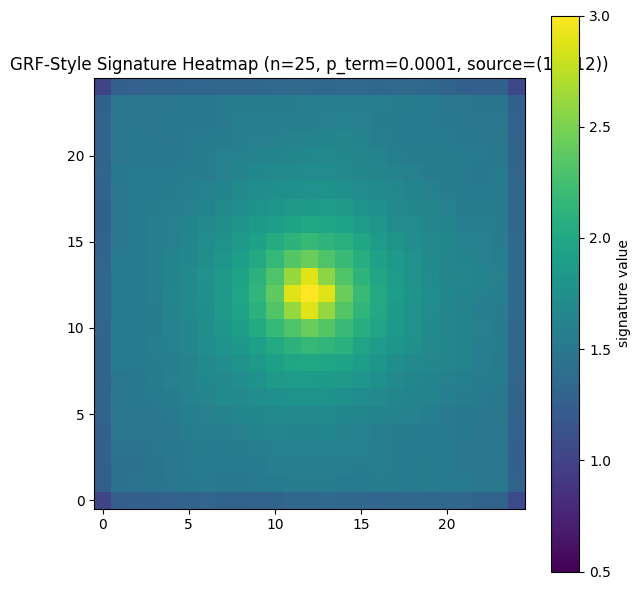

In [61]:
n = 25
p_term = 0.0001
num_walks = 10000
source = (n // 2, n // 2)
gamma = 0.999
signature_fine = generate_signature_vector(n=n, source=source, num_walks=num_walks, p_term=p_term, gamma=gamma)
plot_signature_vector(signature_fine, n=n, p_term=p_term, source=source, vmin=.5, vmax=3.)

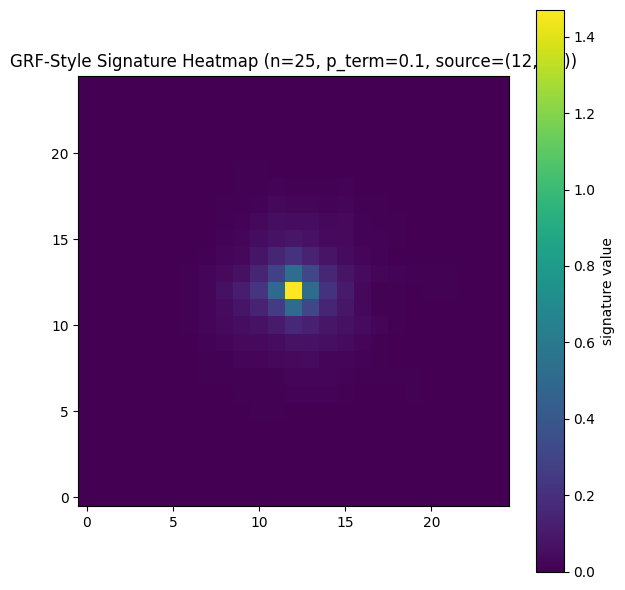

In [81]:
n = 25
p_term = 0.1
num_walks = 1000
source = (n // 2, n // 2)
gamma = 0.9
signature_fine = generate_signature_vector(n=n, source=source, num_walks=num_walks, p_term=p_term, gamma=gamma)
plot_signature_vector(signature_fine, n=n, p_term=p_term, source=source)

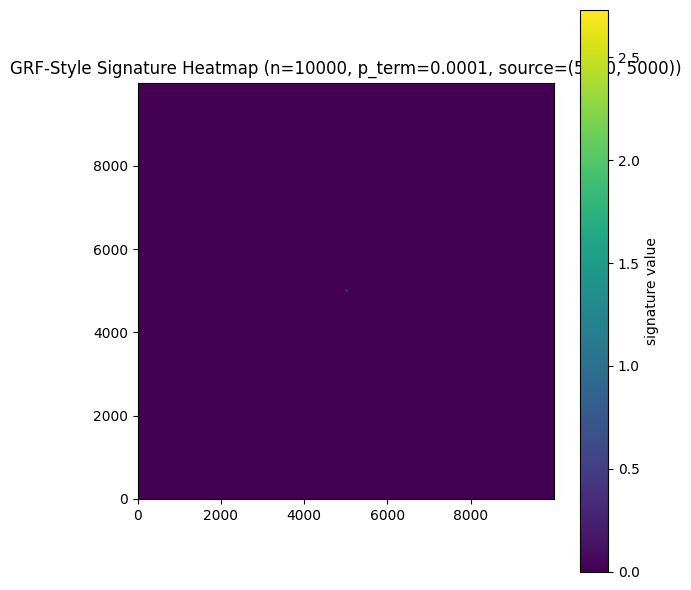

In [ ]:
n = 10000
p_term = 0.0001
num_walks = 1000
source = (n // 2, n // 2)
gamma = 0.999
signature = generate_signature_vector(n=n, source=source, num_walks=num_walks, p_term=p_term, gamma=gamma)
plot_signature_vector(signature, n=n, p_term=p_term, source=source, vmin=0., vmax=None)

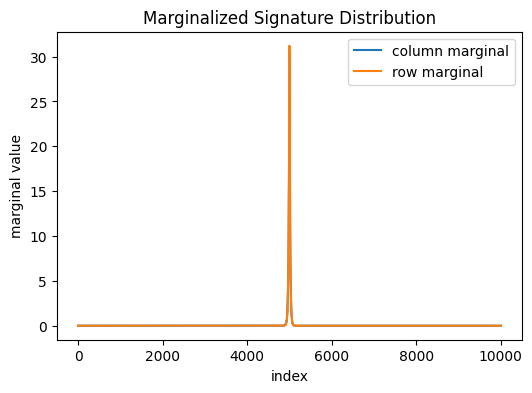

In [4]:
plot_marginalized(signature)

Sum of signature matrix vectors


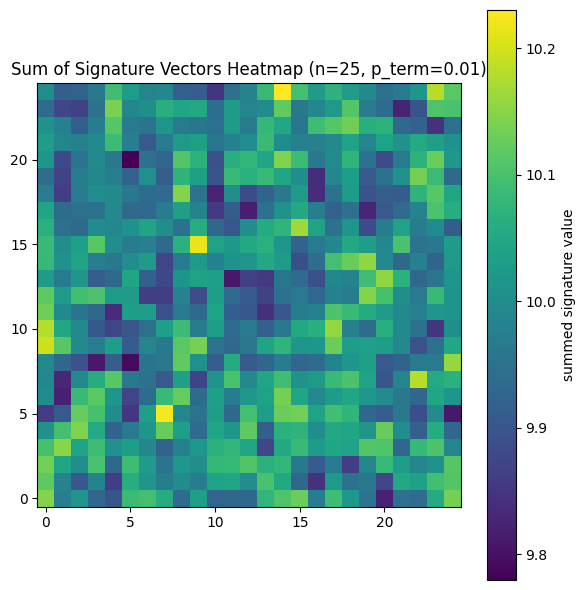

In [ ]:
n = 25
p_term = 0.01
num_walks = 1000
source = (n // 2, n // 2)
gamma = 0.9

signature_vector_matrix = [[np.zeros((n, n), dtype=np.float64) for _ in range(n)] for _ in range(n)]
for i in range(n):
    for j in range(n):
        signature_vector_matrix[i][j] = generate_signature_vector(n=n, source=(i, j), num_walks=num_walks, p_term=p_term, gamma=gamma)

print("Sum of signature matrix vectors")
total_signature = np.sum(signature_vector_matrix, axis=(0, 1))

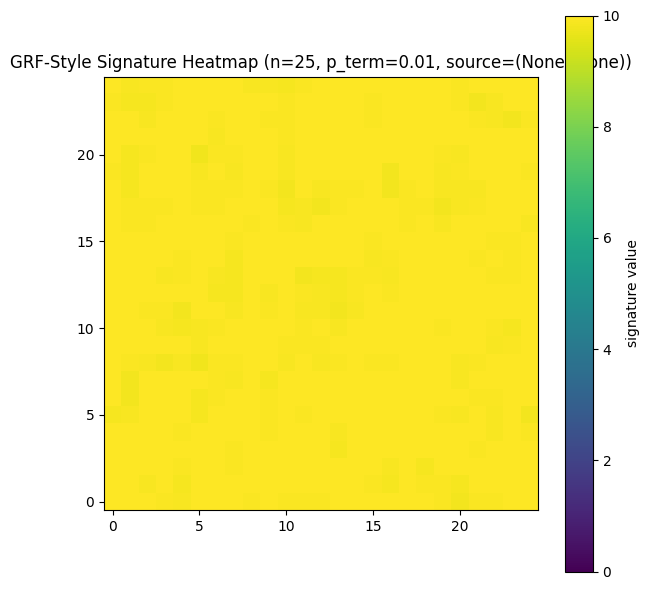

In [94]:
plot_signature_vector(total_signature, n=n, p_term=p_term, source=(None, None), vmin=0., vmax=10.)

Running diffusion → Gaussian...


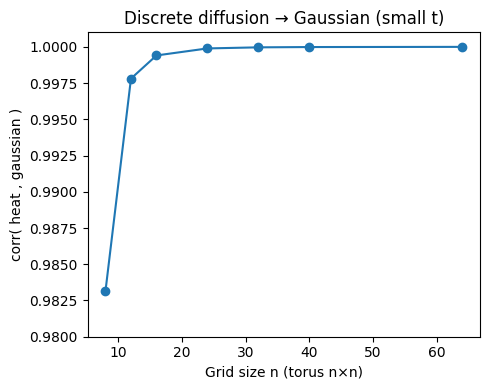

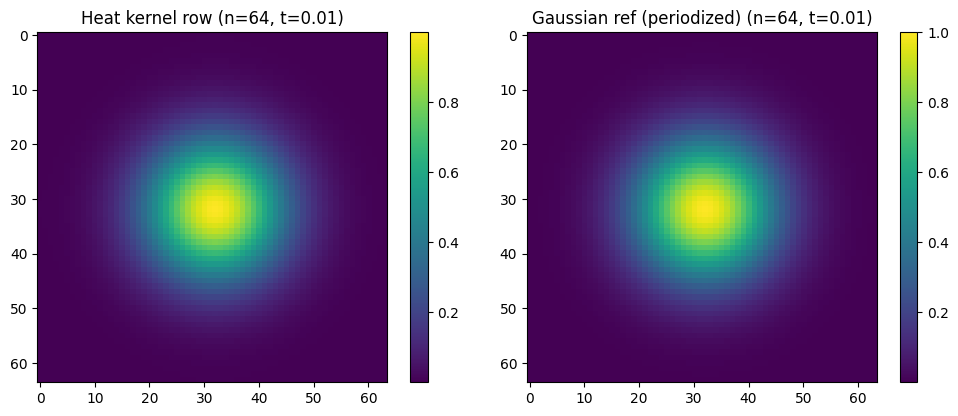

n=  8  corr(heat,gaussian)=0.983156
n= 12  corr(heat,gaussian)=0.997807
n= 16  corr(heat,gaussian)=0.999405
n= 24  corr(heat,gaussian)=0.999890
n= 32  corr(heat,gaussian)=0.999965
n= 40  corr(heat,gaussian)=0.999985
n= 64  corr(heat,gaussian)=0.999997

Running resolvent (discrete → continuum)...


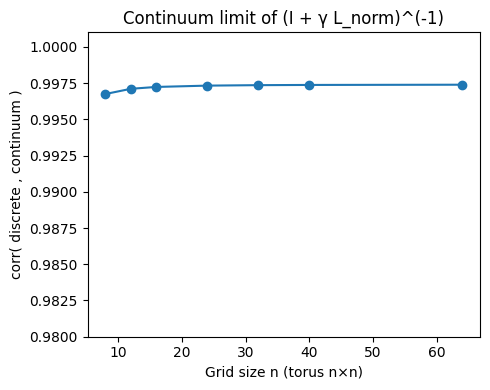

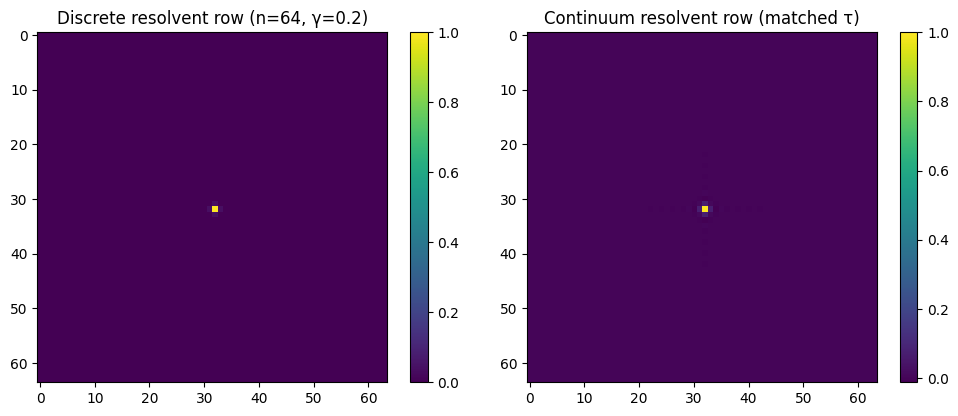

n=  8  corr(discrete,continuum)=0.996746
n= 12  corr(discrete,continuum)=0.997106
n= 16  corr(discrete,continuum)=0.997233
n= 24  corr(discrete,continuum)=0.997324
n= 32  corr(discrete,continuum)=0.997356
n= 40  corr(discrete,continuum)=0.997370
n= 64  corr(discrete,continuum)=0.997386

Running GRF estimator → discrete resolvent (fixed n=24)...


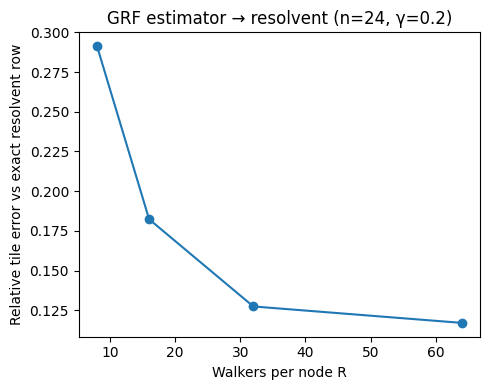

R=  8  rel_tile_err=0.2913
R= 16  rel_tile_err=0.1823
R= 32  rel_tile_err=0.1274
R= 64  rel_tile_err=0.1170


In [95]:
# limit_experiments.py
# ------------------------------------------------------------
# Shows two convergence stories on 2-D torus (periodic grid):
# 1) Discrete diffusion kernel e^{-t L / h^2} → (periodized) Gaussian
# 2) GRF (random-walk) → resolvent (I + γ L_norm)^{-1}, and
#    discrete resolvent → continuum resolvent under τ = γ h^2 / 4
#
# Deps: numpy, matplotlib
# ------------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt


# ================================
# Utilities: torus FFT kernels
# ================================

def heat_kernel_row_torus_fft(n: int, t: float):
    """
    Heat kernel row (impulse response) of exp(-t L / h^2) on n x n torus via FFT.
    Returns (n,n) image normalized to max 1 (shape comparison).
    """
    h = 1.0 / n
    ks = np.arange(n)
    ls = np.arange(n)
    w_k = 2.0 * np.pi * ks / n
    w_l = 2.0 * np.pi * ls / n
    lam = (4.0 - 2.0 * np.cos(w_k)[:, None] - 2.0 * np.cos(w_l)[None, :])  # eigenvalues of comb. Laplacian
    lam_scaled = lam / (h*h)
    spec = np.exp(-t * lam_scaled)                 # spectral multiplier
    k = np.fft.ifft2(spec).real                    # impulse response (row from origin)
    k = np.fft.fftshift(k)                         # center peak for plotting
    k /= (k.max() + 1e-12)
    return k


def gaussian_row_torus(n: int, t: float):
    """
    Periodized Gaussian on [0,1)^2 sampled on an n x n grid; normalized to max 1.
    """
    grid = np.arange(n) / n
    xs, ys = np.meshgrid(grid, grid, indexing='ij')
    # minimum-image distance; center at (0.5, 0.5) to match fftshifted impulse
    dx = (xs - 0.5 + 0.5) % 1.0 - 0.5
    dy = (ys - 0.5 + 0.5) % 1.0 - 0.5
    dist2 = dx*dx + dy*dy
    g = np.exp(-dist2 / (4.0 * t))
    g /= (g.max() + 1e-12)
    return g


def lambda_norm_torus(n: int):
    """Eigenvalues of normalized Laplacian L_norm on n x n torus."""
    ks = np.arange(n)
    ls = np.arange(n)
    w_k = 2.0*np.pi*ks/n
    w_l = 2.0*np.pi*ls/n
    lam = 1.0 - 0.5*(np.cos(w_k)[:,None] + np.cos(w_l)[None,:])  # shape (n,n)
    return lam


def resolvent_row_norm_fft(n: int, gamma: float):
    """
    Discrete resolvent row (impulse) of (I + γ L_norm)^(-1) on torus via FFT.
    Returns (n,n) normalized to max 1.
    """
    lam = lambda_norm_torus(n)
    spec = 1.0 / (1.0 + gamma * lam)
    k = np.fft.ifft2(spec).real
    k = np.fft.fftshift(k)
    k /= (k.max() + 1e-12)
    return k


def continuum_resolvent_row_fft(n: int, gamma: float):
    """
    Continuum resolvent on the unit torus sampled on n x n grid.
    Parameter match: τ = γ * h^2 / 4 (h = 1/n).
    Returns (n,n) normalized to max 1.
    """
    h = 1.0/n
    tau = gamma * (h*h) / 4.0
    ks = np.fft.fftfreq(n) * n  # integer frequencies
    ls = np.fft.fftfreq(n) * n
    kk, ll = np.meshgrid(ks, ls, indexing='ij')
    lam_cont = (2.0*np.pi)**2 * (kk**2 + ll**2)
    spec = 1.0 / (1.0 + tau * lam_cont)
    g = np.fft.ifft2(spec).real
    g = np.fft.fftshift(g)
    g /= (g.max() + 1e-12)
    return g


def corrcoef_flat(A, B):
    a = A.ravel() - A.mean()
    b = B.ravel() - B.mean()
    na = np.linalg.norm(a) + 1e-12
    nb = np.linalg.norm(b) + 1e-12
    return float((a @ b) / (na*nb))


# ================================
# Part 1: Diffusion → Gaussian
# ================================

def experiment_diffusion_to_gaussian(n_list=(8,12,16,24,32,40,64), t=0.01):
    corrs = []
    rows = {}
    for n in n_list:
        heat = heat_kernel_row_torus_fft(n, t)
        gaus = gaussian_row_torus(n, t)
        c = corrcoef_flat(heat, gaus)
        corrs.append((n, c))
        if n == n_list[-1]:
            rows["heat"] = heat
            rows["gauss"] = gaus

    # Convergence plot
    plt.figure(figsize=(5,4))
    plt.plot([n for n,_ in corrs], [c for _,c in corrs], marker='o')
    plt.xlabel("Grid size n (torus n×n)")
    plt.ylabel("corr( heat , gaussian )")
    plt.title("Discrete diffusion → Gaussian (small t)")
    plt.ylim(0.98, 1.001)
    plt.tight_layout()
    plt.show()

    # Visual compare at finest n
    if rows:
        n = n_list[-1]
        plt.figure(figsize=(10,4))
        plt.subplot(1,2,1); plt.imshow(rows["heat"]);  plt.title(f"Heat kernel row (n={n}, t={t})");  plt.colorbar()
        plt.subplot(1,2,2); plt.imshow(rows["gauss"]); plt.title(f"Gaussian ref (periodized) (n={n}, t={t})"); plt.colorbar()
        plt.tight_layout(); plt.show()

    return corrs


# ================================
# Part 2: Random walk (GRF) → Resolvent
# ================================

def grf_features_torus_scaled(n: int, gamma: float, R: int=32, qmc: bool=False, seed: int=0):
    """
    GRF/q-GRF signatures for K = (I + γ L_norm)^(-1) on an n x n torus (degree=4).
    Returns Φ of shape (N, N): per-source signature over all nodes (dense; demo-friendly).
    """
    N = n*n
    rng = np.random.RandomState(seed)

    def move(idx, direction):
        i, j = divmod(idx, n)
        if direction == 0:   i = (i+1) % n
        elif direction == 1: i = (i-1) % n
        elif direction == 2: j = (j+1) % n
        else:                j = (j-1) % n
        return i*n + j

    alpha = gamma / (1.0 + gamma)   # survival prob per step
    p = 1.0 - alpha                 # termination prob per step
    w0 = 1.0 / (1.0 + gamma)        # deposit per visit
    if qmc and (R % 2 == 1):
        R += 1

    Phi = np.zeros((N, N), dtype=np.float64)
    for s in range(N):
        sig = np.zeros(N, dtype=np.float64)
        if not qmc:
            for _ in range(R):
                pos = s
                while True:
                    sig[pos] += w0
                    if rng.rand() < p:
                        break
                    pos = move(pos, rng.randint(4))
        else:
            pairs = R // 2
            for _ in range(pairs):
                pos_a = s; pos_b = s
                alive_a = True; alive_b = True
                while True:
                    if alive_a: sig[pos_a] += w0
                    if alive_b: sig[pos_b] += w0
                    if not alive_a and not alive_b:
                        break
                    u = rng.rand()
                    ua = u; ub = (u + 0.5) % 1.0
                    if alive_a and ua < p: alive_a = False
                    if alive_b and ub < p: alive_b = False
                    if alive_a: pos_a = move(pos_a, rng.randint(4))
                    if alive_b: pos_b = move(pos_b, rng.randint(4))
        Phi[s, :] = sig / float(R)   # MC average
    return Phi


def kernel_from_two_feature_sets(Phi: np.ndarray, Psi: np.ndarray) -> np.ndarray:
    """Symmetric unbiased estimator."""
    return 0.5*(Phi @ Psi.T + Psi @ Phi.T)


def fro_error_tile_from_kernel(K_hat: np.ndarray, tile_true: np.ndarray) -> float:
    """
    Compare a kernel K_hat (N x N) to translation-invariant kernel given by tile_true (n x n).
    Use the center row of K_hat reshaped to (n,n).
    """
    N = K_hat.shape[0]
    n = int(round(np.sqrt(N)))
    assert n*n == N
    center = (n//2)*n + (n//2)
    row = K_hat[center, :].reshape(n, n)
    r = row / (row.max() + 1e-12)
    t = tile_true / (tile_true.max() + 1e-12)
    num = np.linalg.norm(r - t, 'fro')
    den = np.linalg.norm(t, 'fro') + 1e-12
    return float(num/den)


def experiment_grf_to_resolvent(n: int=24, gamma: float=0.2, R_list=(8,16,32,64), seed: int=7):
    """
    Fix n and show GRF estimator error vs R against *discrete* resolvent tile.
    """
    tile_true = resolvent_row_norm_fft(n, gamma)  # discrete exact row (n x n)
    errs = []
    for R in R_list:
        Phi = grf_features_torus_scaled(n=n, gamma=gamma, R=R, qmc=False, seed=seed)
        Psi = grf_features_torus_scaled(n=n, gamma=gamma, R=R, qmc=True,  seed=seed+1)
        K_hat = kernel_from_two_feature_sets(Phi, Psi)
        e = fro_error_tile_from_kernel(K_hat, tile_true)
        errs.append(e)

    plt.figure(figsize=(5,4))
    plt.plot(list(R_list), errs, marker='o')
    plt.xlabel("Walkers per node R")
    plt.ylabel("Relative tile error vs exact resolvent row")
    plt.title(f"GRF estimator → resolvent (n={n}, γ={gamma})")
    plt.tight_layout(); plt.show()
    return list(zip(R_list, errs))


def experiment_resolvent_continuum(n_list=(8,12,16,24,32,40,64), gamma=0.2):
    """
    Show discrete resolvent row → continuum resolvent row as n increases.
    """
    corrs = []
    rows = {}
    for n in n_list:
        disc = resolvent_row_norm_fft(n, gamma)
        cont = continuum_resolvent_row_fft(n, gamma)
        c = corrcoef_flat(disc, cont)
        corrs.append((n, c))
        if n == n_list[-1]:
            rows["disc"] = disc
            rows["cont"] = cont

    plt.figure(figsize=(5,4))
    plt.plot([n for n,_ in corrs], [c for _,c in corrs], marker='o')
    plt.xlabel("Grid size n (torus n×n)")
    plt.ylabel("corr( discrete , continuum )")
    plt.title("Continuum limit of (I + γ L_norm)^(-1)")
    plt.ylim(0.98, 1.001)
    plt.tight_layout(); plt.show()

    if rows:
        n = n_list[-1]
        plt.figure(figsize=(10,4))
        plt.subplot(1,2,1); plt.imshow(rows["disc"]); plt.title(f"Discrete resolvent row (n={n}, γ={gamma})"); plt.colorbar()
        plt.subplot(1,2,2); plt.imshow(rows["cont"]); plt.title("Continuum resolvent row (matched τ)"); plt.colorbar()
        plt.tight_layout(); plt.show()

    return corrs


# ================================
# Main
# ================================

if __name__ == "__main__":
    # 1) Diffusion → Gaussian
    print("Running diffusion → Gaussian...")
    diff_corrs = experiment_diffusion_to_gaussian(n_list=(8,12,16,24,32,40,64), t=0.01)
    for n, c in diff_corrs:
        print(f"n={n:>3d}  corr(heat,gaussian)={c:.6f}")

    # 2) Discrete resolvent → Continuum resolvent
    print("\nRunning resolvent (discrete → continuum)...")
    res_corrs = experiment_resolvent_continuum(n_list=(8,12,16,24,32,40,64), gamma=0.2)
    for n, c in res_corrs:
        print(f"n={n:>3d}  corr(discrete,continuum)={c:.6f}")

    # 3) GRF random walk → Discrete resolvent (Monte-Carlo convergence)
    print("\nRunning GRF estimator → discrete resolvent (fixed n=24)...")
    errs = experiment_grf_to_resolvent(n=24, gamma=0.2, R_list=(8,16,32,64), seed=7)
    for R, e in errs:
        print(f"R={R:>3d}  rel_tile_err={e:.4f}")


In [96]:
diff_corrs

[(8, 0.9831556991771833),
 (12, 0.9978070543552939),
 (16, 0.9994048780008835),
 (24, 0.9998896991396279),
 (32, 0.9999646282216355),
 (40, 0.999984791280893),
 (64, 0.9999968339398819)]